# 0.0 Imports

In [1]:
import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
import datetime

# 0.1. Helper Functions

# 0.2 Loading data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 DESCRIÇÃO DOS DADOS

In [3]:
df1 = df_raw.copy()
df1

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


# 1.1 RENAME COLUMNS

In [4]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

# 1.2 DATA DIMENSION

In [5]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


# 1.3 DATA TYPES

In [6]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 CHECK NA

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 1.5 Fillout NA

In [8]:
#competition_distance (descobri um valor máximo para o compedidor, estrapolei o valor para ser desconsiderado e apliquei este mesmo valor desconsiderado nas linhas onde não haviam este tipo de transformação)
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan(x) else x) 

#competition_open_since_month (caso não exista uma data de abertura do competidor mais proximo, iremos assumir que esta data é o mês de venda)
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year   (mesma ideia de cima, vamos entender o porquê mais a frente)  
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
    
#promo2_since_week (mesma ideia de cima, vamos entender o porquê mais a frente) 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year (mesma ideia de cima, vamos entender o porquê mais a frente)

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

#transformando os NA's da coluna 'promo_interval' em 0:

df1['promo_interval'].fillna(0, inplace=True)

#Mapeando o mês, de acordo com as atribuições do dicionário month_map, atribuimos a colina 'month_map' os meses respectivos ao mês de venda

df1['month_map'] = df1['date'].dt.month.map(month_map)

#Se o mês correspondente a coluna 'month_map' estiver em algum dos meses listados na coluna 'promo_interval', retornar 1, else retornar zero

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        

In [9]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

# 1.6 Change dtypes

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

# 1.7 Descriptive Statistical

In [11]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

# 1.7.1 Numerical Attributes

In [12]:
# Central Tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion Metrics - min, max, std, range, kurtosis, skew

dm1 = pd.DataFrame(num_attributes.apply(np.min)).T
dm2 = pd.DataFrame(num_attributes.apply(np.max)).T
dm3 = pd.DataFrame(num_attributes.apply(np.std)).T
dm4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dm5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dm6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenando para melhorar a visualização





In [13]:
m = pd.concat([dm1,dm2,dm4,ct1,ct2,dm3,dm5,dm6]).T.reset_index()

In [14]:
m.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']

In [15]:
m

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


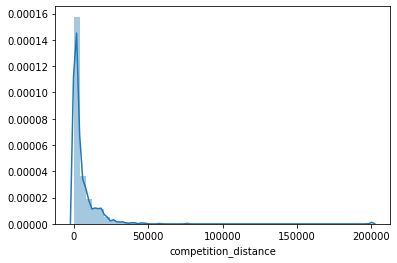

In [16]:
sns.distplot(df1['competition_distance'])

# 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

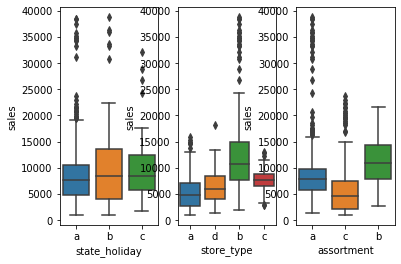

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.subplot(1, 3, 1)
sns.boxplot (x='state_holiday',y='sales',data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot (x='store_type',y='sales',data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot (x='assortment',y='sales',data=aux1)

# 2. FEATURE ENGINEERING

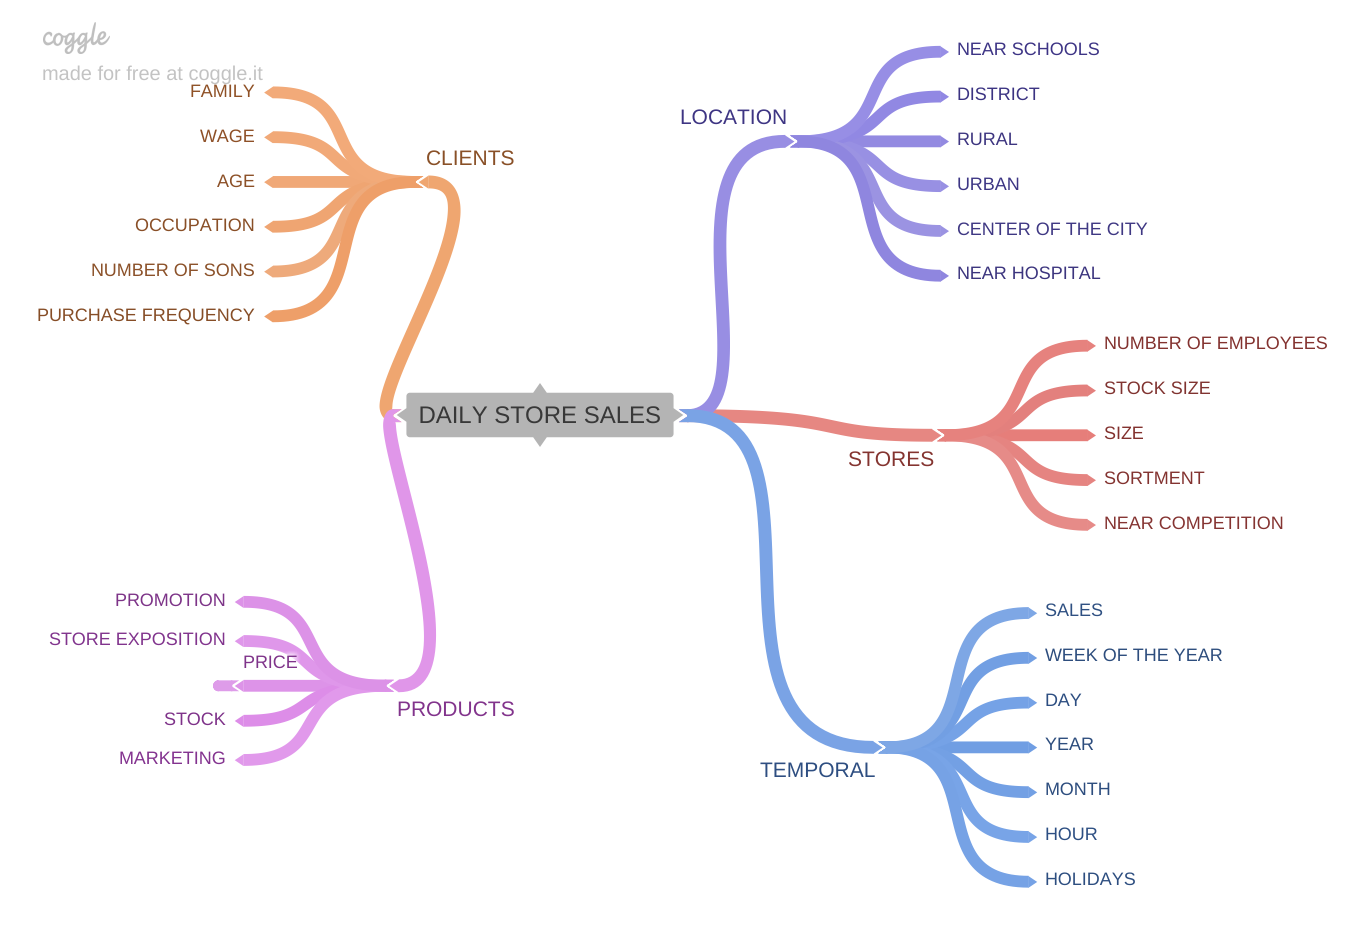

In [19]:
Image('images/MindMapHyphotesis.png')

# 2.1 Hypothesis Creation

In [20]:
df2 = df1.copy()

# 2.1.1 Store Hypothesis

#1 Lojas que investem mais em marketing deveriam vender mais
#2 Lojas com maior exposição de produto deveriam vender mais
#3 Lojas com produtos com preço menor deveriam vender mais
#5 Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais
#6 Lojas com promoçoes ativas por mais tempo deveriam vender mais
#7 Lojas com mais dias de promoção deveriam vender mais
#8 Lojas com mais promoções consecutivas deveriam vender mais

# 2.1.2 Product Hypothesis

#1 Lojas com número maior de funcionários deveriam vender mais
#2 Lojas com maior capacidade de estoque deveriam vender mais
#3 Lojas com maior porte deveriam vender mais
#4 Lojas com maior sortimentos deveriam vender mais
#5 Lojas com competidores mais próximos deveriam vender menos
#6 Lojas com competidores a mais tempo deveriam vender mais

# 2.1.3 Time Hypothesis

#1 Lojas abertas durantes o feriado de Natal deveriam vender mais 
#2 Lojas deveriam vender mais ao longo dos anos
#3 Lojas deveriam vender mais no segundo semestre do ano
#4 Lojas deveriam vender mais depois do dia 10 de cada mês
#5 Lojas deveriam vender menos aos finais de semana
#6 Lojas deveriam vender menos durante os feriados escolares

# 2.2 Lista final de hipóteses (Separando o que eu tenho dado para testar as hipoteses)

#1 Lojas com maior sortimentos deveriam vender mais
#2 Lojas com competidores mais proximos deveriam vender mais
#3 Lojas com competidores a mais tempo deveriam vender mais
#4 Lojas com promoçoes ativas por mais tempo deveriam vender mais
#5 Lojas com mais dias de promoção deveriam vender mais
#6 Lojas com mais promoçoes consecutivas deveriam vender mais
#7 Lojas abertas durantes o feriado de Natal deveriam vender mais
#8 Lojas deveriam vender mais ao longo dos anos
#9 Lojas deveriam vender mais no segundo semestre do ano
#10 Lojas deveriam vender mais depois do dia 10 de cada mês
#11 Lojas deveriam vender menos aos finais de semana
#12 Lojas deveriam vender menos durante os feriados escolares

# 2.3 Feature Engineering

In [21]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week year
df2['week_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since

df2['competition_since'] = df2.apply(lambda x : datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


#assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended' )

#state_holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas') 

# 3 - FILTRAGEM VARIAVEIS

In [22]:
df3 = df2.copy()

# 3.1 Filtragem das linhas

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]


# 3.2 Filtragem das colunas

In [24]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

In [25]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,christmas,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,christmas,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,christmas,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,christmas,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,christmas,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
